In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential, Model, load_model
from keras.layers import  Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, Reshape, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#import keras_tuner as kt
#for visualising neural network
from keras.utils import plot_model

# Importing Data

In [ ]:
Vx = pd.read_excel(r'/content/X1_2d.xlsx', header=None)
print(Vx.shape)
Vx.head()

(2000, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.262450,0.295608,0.326179,0.336112,0.390381,0.486186,0.561427,0.760142,0.808377,0.994028,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
1,0.000000,0.021747,0.024287,0.091087,0.091329,0.128114,0.237584,0.247202,0.314967,0.383035,...,0.468530,0.512017,0.542879,0.568091,0.572286,0.688301,0.799812,0.903531,0.976851,1
2,0.097382,0.101820,0.136128,0.169058,0.250484,0.378114,0.536421,0.750164,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
3,0.147636,0.198480,0.214883,0.225105,0.240041,0.248907,0.272599,0.291418,0.367609,0.470712,...,0.578315,0.764955,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
4,0.000000,0.017936,0.022071,0.047653,0.056751,0.071771,0.114469,0.134870,0.138619,0.162644,...,0.237803,0.284251,0.369232,0.440950,0.460440,0.620451,0.670391,0.864665,0.925050,1


In [ ]:
Vy = pd.read_excel(r'/content/Y1_2d.xlsx', header=None)
print(Vy.shape)
Vy.head()

(2000, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.237646,0.371151,0.637877,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0000,1.000000,1.000000,1
1,0.092731,0.129868,0.200575,0.407838,0.504153,0.630146,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0000,1.000000,1.000000,1
2,0.000000,0.047075,0.135211,0.185226,0.190946,0.211833,0.213134,0.276487,0.311037,0.407363,...,0.507634,0.508015,0.601475,0.68343,0.735647,0.836173,0.9029,0.906702,0.950314,1
3,0.722302,0.845067,0.859313,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0000,1.000000,1.000000,1
4,0.576808,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0000,1.000000,1.000000,1


In [ ]:
disp = pd.read_excel(r'/content/output_values_2d.xlsx', header=None)
print(disp.shape)
disp.head()

(2000, 1)


,0
0,-0.000230
1,-0.000323
2,-0.000359
3,-0.000231
4,-0.000282


In [ ]:
input_data = np.concatenate((Vx, Vy), axis=1)
#input_data = input_data.reshape([2000,42,1])
input_data.shape

(2000, 42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_data, disp, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 42), (400, 42), (1600, 1), (400, 1))

In [ ]:
# Instantiate the MinMaxScaler
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# Custom Loss function

In [ ]:
def custom_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [ ]:
def custom_mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

In [ ]:
# Define the custom huber loss function
def huber_loss(y_true, y_pred, delta=1.0):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic_part = tf.minimum(abs_error, delta)
    linear_part = abs_error - quadratic_part
    return tf.reduce_mean(0.5 * tf.square(quadratic_part) + delta * linear_part)

# Custom metrics

In [ ]:
# Define the custom R2 metric function
def r2_metric(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [ ]:
def custom_mape(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    error = tf.abs((y_true - y_pred) / tf.maximum(tf.abs(y_true), tf.keras.backend.epsilon()))
    return 100. * tf.reduce_mean(error)

In [ ]:
def custom_normalized_l2_norm(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    error = y_true - y_pred
    l2_norm = tf.norm(error, ord='euclidean')
    l2_norm = l2_norm/tf.maximum(tf.norm(y_true, ord='euclidean'), tf.keras.backend.epsilon())
    return l2_norm

# Custom Activation Function

In [ ]:
def custom_relu(x):
    return tf.maximum(0.0, x)

In [ ]:
def custom_tanh(x):
    return (tf.exp(x) - tf.exp(-x)) / (tf.exp(x) + tf.exp(-x))

In [ ]:
def custom_sigmoid(x):
    return 1 / (1 + tf.exp(-x))

In [ ]:
def custom_activation(x):
    return tf.square(x)

# Custom Layer

In [ ]:
# Custom dense layer
class CustomDense(tf.keras.layers.Layer):  # inherits from layers module
    def __init__(self, units, activation=None): #class constructor
        super(CustomDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b)

# Building the model


In [ ]:
# Clear existing model
tf.keras.backend.clear_session()
#define model
network1d = Sequential()
network1d.add(Conv1D(filters=32, kernel_size=3, activation=custom_relu, input_shape=(42,1)))
network1d.add(MaxPooling1D(pool_size=2))

network1d.add(Conv1D(filters=32, kernel_size=3, activation=custom_relu))
network1d.add(MaxPooling1D(pool_size=2))
network1d.add(Flatten())

network1d.add(CustomDense(units = 256, activation=custom_relu))
network1d.add(CustomDense(units = 256, activation=custom_relu))
network1d.add(CustomDense(units = 1))
network1d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9, 32)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 custom_dense (CustomDense)  (None, 256)               7

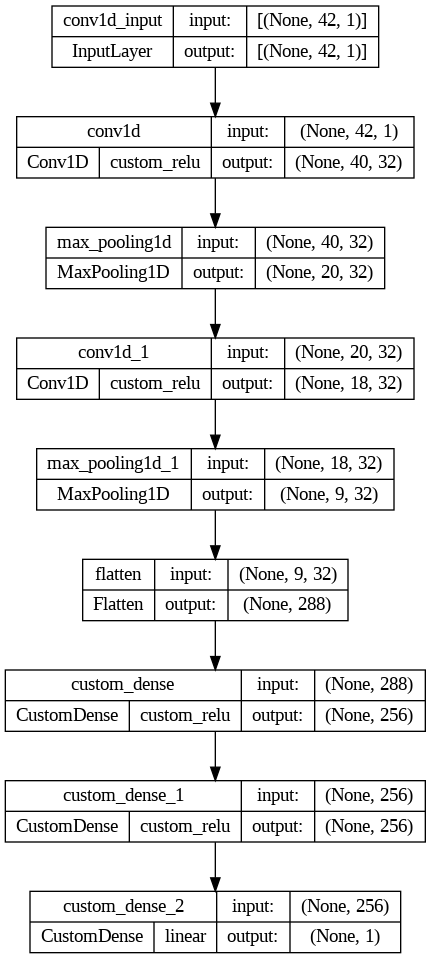

In [ ]:
plot_model(network1d, show_shapes=True, show_layer_names=True, show_layer_activations=True)

# Custom Training the model

In [ ]:
initial_learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [ ]:
def lr_schedule(epoch):
    if epoch < 10:
        return initial_learning_rate
    elif 10 <= epoch < 20:
        return initial_learning_rate * 0.1
    else:
        return initial_learning_rate * 0.01

In [ ]:
@tf.function
def train_step(inputs, targets, epoch):
    with tf.GradientTape() as tape:
        predictions = network1d(inputs, training=True)
        loss = huber_loss(targets, predictions)
        # Compute additional metrics
        metric1_value = r2_metric(targets, predictions)
        metric2_value = custom_mape(targets, predictions)

    gradients = tape.gradient(loss, network1d.trainable_variables)
    optimizer.learning_rate = lr_schedule(epoch)
    optimizer.apply_gradients(zip(gradients, network1d.trainable_variables))
    return loss, metric1_value, metric2_value

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_scaled))
validation_size = int(0.2 * len(train_dataset))
train_dataset_shuffled = train_dataset.shuffle(buffer_size=len(train_dataset))
# Create the validation set by taking the first `validation_size` elements from the shuffled train_dataset
validation_dataset = train_dataset_shuffled.take(validation_size).batch(32)
# Create the training set by skipping the first `validation_size` elements from the shuffled train_dataset
train_dataset_final = train_dataset_shuffled.skip(validation_size).batch(32)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    # Training loop
    for inputs, targets in train_dataset_final:
        loss, metric1_value, metric2_value = train_step(inputs, targets, epoch)

    # Evaluation loop
    val_loss = 0
    val_steps = 0
    for val_inputs, val_targets in validation_dataset:
        val_predictions = network1d(val_inputs, training=False)
        val_loss += huber_loss(val_targets, val_predictions)
        val_steps += 1
    val_loss /= val_steps

    print(f'Epoch {epoch+1}, Loss: {loss.numpy()}, Metric: {metric1_value.numpy(), metric2_value.numpy()} Validation Loss: {val_loss.numpy()}')

Epoch 1, Loss: 3.4408334613544866e-05, Metric: (0.998525, 1.1992749) Validation Loss: 4.4040811189915985e-05
Epoch 2, Loss: 9.119080641539767e-05, Metric: (0.9972211, 82.293625) Validation Loss: 8.526120655005798e-05
Epoch 3, Loss: 3.64915031241253e-05, Metric: (0.998283, 1.1958222) Validation Loss: 3.3037598768714815e-05
Epoch 4, Loss: 0.00019614555640146136, Metric: (0.9877192, 3.1942248) Validation Loss: 5.422065805760212e-05
Epoch 5, Loss: 0.00011118802649434656, Metric: (0.99664026, 2.4123557) Validation Loss: 0.00014768948312848806
Epoch 6, Loss: 3.750243195099756e-05, Metric: (0.9982569, 2.0397437) Validation Loss: 4.753395478473976e-05
Epoch 7, Loss: 4.086099215783179e-05, Metric: (0.9984902, 10.126166) Validation Loss: 8.149394852807745e-05
Epoch 8, Loss: 2.6902145691565238e-05, Metric: (0.99855673, 0.9309655) Validation Loss: 4.176954098511487e-05
Epoch 9, Loss: 1.68449550983496e-05, Metric: (0.99934, 15825.09) Validation Loss: 2.546799078118056e-05
Epoch 10, Loss: 2.62948560

# Using learning rate scheduler

In [ ]:
def custom_lr_scheduler(epoch, initial_learning_rate):
    if epoch < 10:
        return initial_learning_rate
    elif 10 <= epoch < 20:
        return initial_learning_rate * 0.1
    else:
        return initial_learning_rate * 0.01

In [ ]:
network1d.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=huber_loss, metrics=[r2_metric,custom_mape,custom_normalized_l2_norm], run_eagerly=True)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    # Update learning rate for the next epoch using the custom_lr_scheduler
    new_learning_rate = custom_lr_scheduler(epoch, initial_learning_rate)
    optimizer.learning_rate = new_learning_rate

    # Perform training steps
    network1d.fit(X_train, y_train_scaled, batch_size=32, validation_split=0.2)

40/40 [==============================] - 3s 85ms/step - loss: 1.2512e-05 - r2_metric: 0.9995 - custom_mape: 1287.4673 - custom_normalized_l2_norm: 0.0074 - val_loss: 1.4721e-05 - val_r2_metric: 0.9994 - val_custom_mape: 1.1070 - val_custom_normalized_l2_norm: 0.0079
